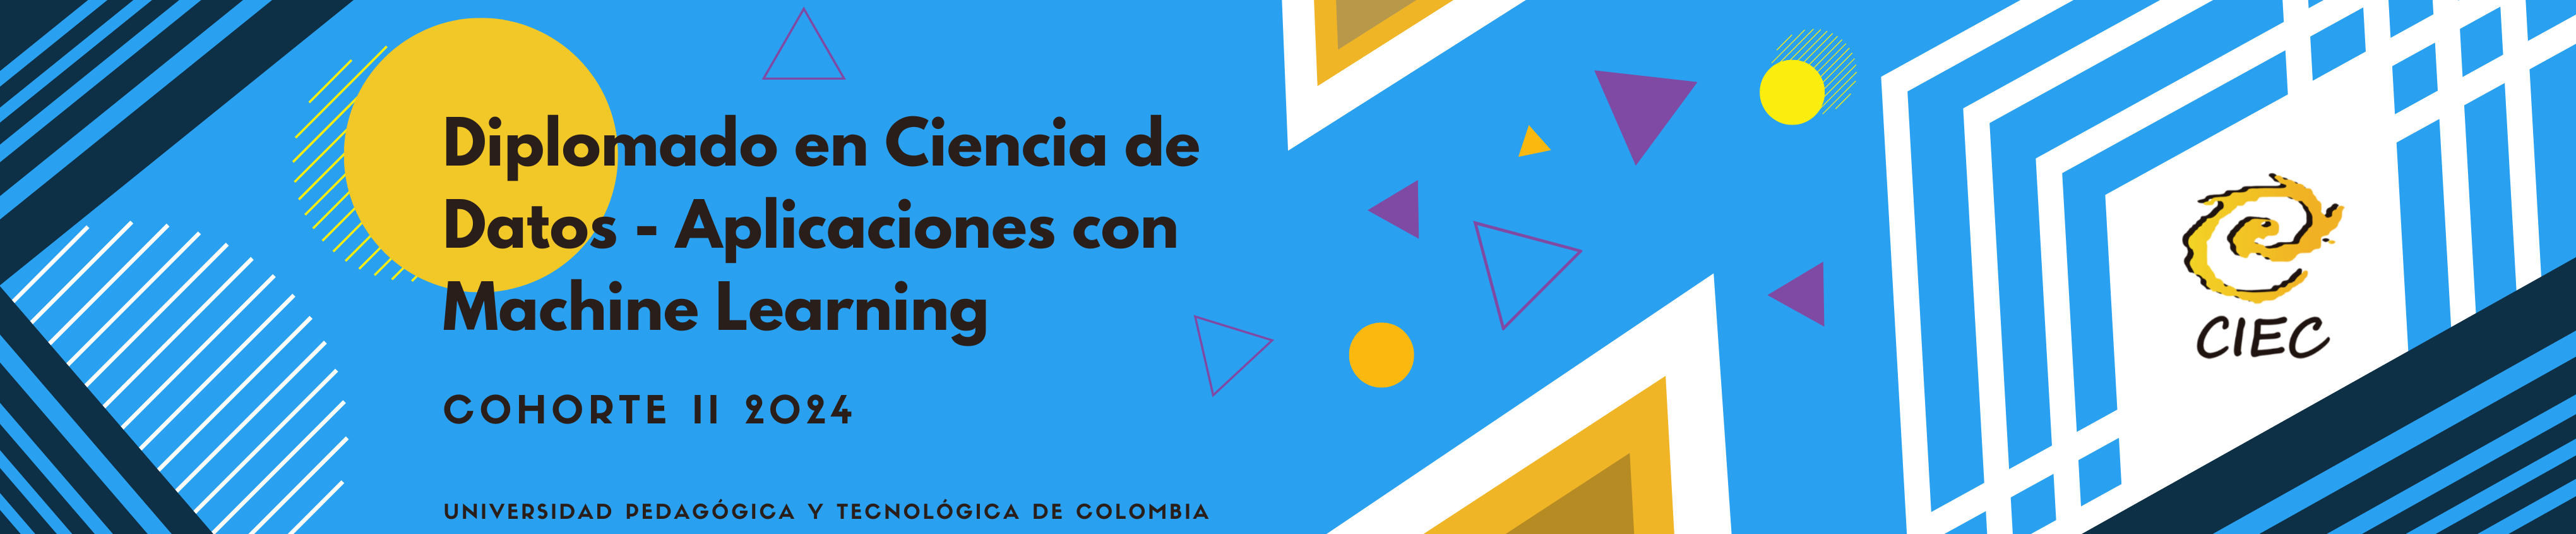

<h1 style="color: #FECB05; text-align: center;"> Fine Tuning y Transfer Learning</h1>

<h2 style="color: #007ACC;">Autores</h2>

- [Juan Felipe Contreras Alcívar](https://www.linkedin.com/in/juanf-contreras/)

---

<h2 style="color: #007ACC;">Tabla de contenido</h2>

- [<span style="color: #005C99;">Introducción</span>](#introduction)
- [<span style="color: #005C99;">Introducción al Transfer Learning</span>](#dim-curse)
- [<span style="color: #005C99;">Ejemplo de implementación en Keras </span>](#dim-curse)
- [<span style="color: #005C99;">Introducción al Fine Tuning</span>](#dim-curse)
- [<span style="color: #005C99;">Hugging Face</span>](#dim-curse)

---

<h2 style="color: #007ACC;"> Introducción </h2>

El aprendizaje profundo (Deep Learning) ha demostrado ser una herramienta poderosa para resolver problemas complejos en áreas como visión por computadora, procesamiento de lenguaje natural y bioinformática. Sin embargo, el entrenamiento de modelos desde cero (también conocido como entrenamiento completo) puede ser prohibitivo en términos de tiempo, recursos computacionales y cantidad de datos necesarios. Es aquí donde Transfer Learning y Fine-Tuning emergen como técnicas fundamentales para aprovechar modelos preentrenados y adaptarlos a nuevas tareas, reduciendo drásticamente los costos de desarrollo y mejorando la eficiencia.

<h2 style="color: #007ACC;"> Introducción al Transfer Learning </h2>

El Transfer Learning se basa en el concepto de transferir el conocimiento aprendido por un modelo en una tarea base (como la clasificación de imágenes genéricas) y aplicarlo en una tarea relacionada, pero diferente (por ejemplo, la clasificación de imágenes médicas). Esto es posible porque las primeras capas de un modelo preentrenado aprenden características genéricas de los datos, como bordes, texturas y patrones básicos, que son útiles para muchas tareas.

<img src="../img/TL.jpg">

Fuente: [Understanding Transfer Learning for Deep Learning](https://www.analyticsvidhya.com/blog/2021/10/understanding-transfer-learning-for-deep-learning/)

El aprendizaje por transferencia ofrece varias ventajas, entre ellas la reducción del tiempo de entrenamiento, el mejor rendimiento de las redes neuronales (en muchos casos) y la capacidad de trabajar de manera efectiva con datos limitados.

Entrenar un modelo neuronal desde cero generalmente requiere una cantidad considerable de datos, que no siempre están disponibles. El aprendizaje por transferencia en redes neuronales convolucionales (CNN) aborda este desafío de manera efectiva.

<h2 style="color: #007ACC;"> Ejemplo de implementación en Keras </h2>

In [1]:
# data handling
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt

# machine learning
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# neural networks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout, LeakyReLU
import tensorflow as tf
from keras.regularizers import L2
from keras.callbacks import EarlyStopping
from keras.applications import VGG16
from tensorflow.keras.models import Model

from tensorflow.keras.regularizers import l2

import os
import random
import warnings
import itertools

warnings.filterwarnings('ignore')

In [2]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def plot_history(history):
    # Extract data from the history object
    history_dict = history.history
    
    # Extract metrics from history
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    accuracy = history_dict.get('accuracy')
    val_accuracy = history_dict.get('val_accuracy')
    
    epochs = range(1, len(loss) + 1)
    
    # Plot training and validation loss
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [3]:
metadata_dir = '../data/meta_data'

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
df = pd.read_csv(os.path.join(metadata_dir, 'metadata_resized.csv'), sep=';')
df.head()

,name,img_size,min_pixel,max_pixel,train_test,label
0,C118P79ThinF_IMG_20151002_105018_cell_150.png,"(128, 128)",0,222,train,parasitized
1,C13NThinF_IMG_20150614_131318_cell_179.png,"(128, 128)",0,225,train,parasitized
2,C189P150ThinF_IMG_20151203_142224_cell_84.png,"(128, 128)",0,196,train,parasitized
3,C91P52ThinF_IMG_20150821_123116_cell_189.png,"(128, 128)",0,225,train,parasitized
4,C84P45ThinF_IMG_20150818_101226_cell_98.png,"(128, 128)",0,221,train,parasitized


In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
X_train = df[df['train_test']=='train'][['name', 'label']]
X_test = df[df['train_test']=='test'][['name', 'label']]

In [8]:
X_train, X_val = train_test_split(X_train, test_size=0.2, stratify=X_train['label'], random_state=42)

In [9]:
image_size, image_size, channels, bat_size = 128, 128, 3, 36

In [10]:
data_dir = '../data/resized'

In [11]:
train_generator = train_datagen.flow_from_dataframe(X_train,
                                                    directory = data_dir,
                                                    x_col= 'name',
                                                    y_col= 'label',
                                                    batch_size = bat_size,
                                                    target_size = (image_size,image_size)
                                                   )

val_generator = test_datagen.flow_from_dataframe(X_val,
                                                 directory = data_dir,
                                                 x_col= 'name',
                                                 y_col= 'label',
                                                 batch_size = bat_size,
                                                 target_size = (image_size,image_size),
                                                 shuffle=False
                                                 )

test_generator = test_datagen.flow_from_dataframe(X_test,
                                                  directory = data_dir,
                                                  x_col= 'name',
                                                  y_col= 'label',
                                                  batch_size = bat_size,
                                                  target_size = (image_size,image_size),
                                                  shuffle=False
                                                 )

Found 19966 validated image filenames belonging to 2 classes.
Found 4992 validated image filenames belonging to 2 classes.
Found 2600 validated image filenames belonging to 2 classes.


In [12]:
# Load the VGG16 network
VGG16_model = VGG16(weights='imagenet', 
                    include_top=False, 
                    input_shape=(image_size, image_size, channels))

In [13]:
# Freeze the convolutional base
for layer in VGG16_model.layers:
    layer.trainable = False

In [14]:
# Add custom top layers
x = VGG16_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

In [15]:
# Create the model
model_tl = Model(inputs=VGG16_model.input, outputs=predictions)

In [16]:
# Compile the model
model_tl.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

In [17]:
model_tl.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [18]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
]

In [19]:
# Train the model
history_tl = model_tl.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100


2024-11-25 16:12:49.148093: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


555/555 [==============================] - 482s 869ms/step - loss: 0.2568 - accuracy: 0.8915 - val_loss: 0.1569 - val_accuracy: 0.9407 - lr: 1.0000e-04
Epoch 2/100
555/555 [==============================] - 485s 875ms/step - loss: 0.1612 - accuracy: 0.9414 - val_loss: 0.1323 - val_accuracy: 0.9533 - lr: 1.0000e-04
Epoch 3/100
555/555 [==============================] - 485s 875ms/step - loss: 0.1408 - accuracy: 0.9496 - val_loss: 0.1244 - val_accuracy: 0.9553 - lr: 1.0000e-04
Epoch 4/100
555/555 [==============================] - 488s 880ms/step - loss: 0.1306 - accuracy: 0.9541 - val_loss: 0.1216 - val_accuracy: 0.9561 - lr: 1.0000e-04
Epoch 5/100
555/555 [==============================] - 487s 878ms/step - loss: 0.1233 - accuracy: 0.9567 - val_loss: 0.1349 - val_accuracy: 0.9489 - lr: 1.0000e-04
Epoch 6/100
555/555 [==============================] - 490s 882ms/step - loss: 0.1154 - accuracy: 0.9598 - val_loss: 0.1415 - val_accuracy: 0.9477 - lr: 1.0000e-04
Epoch 7/100
555/555 [=======

In [20]:
result = model_tl.predict(test_generator, batch_size = bat_size,verbose = 0)

y_pred = np.argmax(result, axis = 1)

y_true = test_generator.labels

In [21]:
classes = list(train_generator.class_indices.keys())

In [22]:
cm = confusion_matrix(y_true, y_pred)

Confusion matrix, without normalization


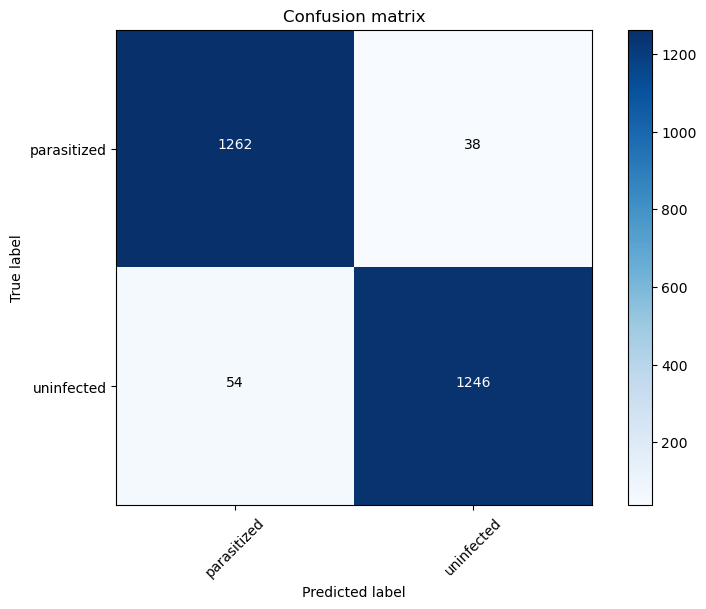

In [23]:
plot_confusion_matrix(cm, classes)

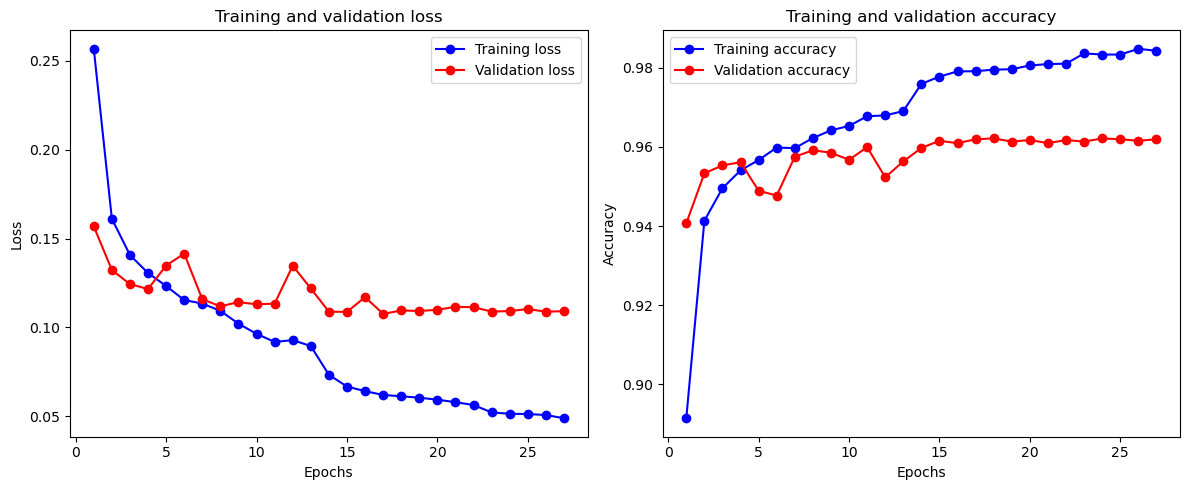

In [25]:
plot_history(history_tl)

<h2 style="color: #007ACC;"> Introducción al Fine Tuning</h2>

El **Fine-Tuning**, o ajuste fino, es una técnica avanzada dentro del aprendizaje profundo que permite optimizar modelos preentrenados para tareas específicas. Esta metodología se basa en el principio de transferir conocimiento previamente adquirido por un modelo en una tarea genérica y ajustarlo a los requisitos particulares de una nueva tarea, maximizando la eficacia y reduciendo los recursos necesarios.

El concepto de Fine-Tuning surge como una solución efectiva para superar las limitaciones de datos y recursos computacionales. Entrenar un modelo desde cero no solo es costoso en términos de tiempo y capacidad de procesamiento, sino que también exige grandes volúmenes de datos etiquetados. En contraste, el ajuste fino aprovecha las características generales aprendidas por un modelo preentrenado en grandes conjuntos de datos, como patrones básicos y representaciones profundas, para adaptarlas a dominios más específicos. 

En el proceso de Fine-Tuning, se toma un modelo previamente entrenado y se modifican algunos de sus parámetros para que sean más adecuados a la tarea objetivo. Esto puede implicar la reentrenamiento de todas las capas del modelo o, más comúnmente, solo de las capas superiores, dejando las capas iniciales intactas para conservar las características genéricas. El ajuste fino requiere un enfoque delicado, ya que es fundamental preservar el conocimiento útil del modelo original mientras se adapta a las particularidades de los nuevos datos.

Esta técnica es especialmente útil en situaciones donde los datos disponibles son limitados, pero la tarea específica difiere lo suficiente de la tarea original como para justificar ajustes adicionales. Por ejemplo, un modelo de reconocimiento de imágenes entrenado en un conjunto de datos genérico como ImageNet puede ajustarse finamente para clasificar imágenes médicas. De manera similar, modelos de lenguaje como BERT pueden adaptarse a tareas específicas como análisis de sentimientos o clasificación de textos legales.

El Fine-Tuning representa un equilibrio entre aprovechar el conocimiento preexistente y personalizar un modelo para nuevas aplicaciones, haciendo que sea una herramienta indispensable en el arsenal del aprendizaje profundo. Su implementación no solo mejora el rendimiento del modelo, sino que también democratiza el uso de redes neuronales avanzadas, permitiendo su aplicación incluso en entornos con recursos limitados.

<img src="../img/FT.webp">

Fuente: [Unlock the Power of Fine-Tuning Pre-Trained Models in TensorFlow & Keras](https://learnopencv.com/fine-tuning-pre-trained-models-tensorflow-keras/)

<h3 style="color: #007ACC;"> Fine Tuning Total </h3>

En este enfoque, todo el modelo preentrenado se entrena nuevamente en el conjunto de datos objetivo $𝐷_{objetivo}$. Esto implica que tanto las capas iniciales (extractoras de características generales) como las capas superiores (más especializadas) son ajustadas.

**Características:**

- Todas las capas del modelo son actualizadas durante el entrenamiento.
- Se utiliza una tasa de aprendizaje baja para evitar sobrescribir los parámetros preentrenados.
- Es más efectivo cuando el conjunto de datos objetivo $𝐷_{objetivo}$ es grande y el dominio objetivo es diferente al dominio de origen.

**Ventajas:**

- Permite adaptar completamente el modelo al dominio objetivo.
- Útil en tareas donde las características preentrenadas generales no son suficientes para lograr un buen rendimiento.

**Desventajas:**

- Computacionalmente costoso
- Mayor riesgo de sobreajuste si el conjunto de datos objetivo es pequeño.

<h3 style="color: #007ACC;"> Fine Tuning Parcial </h3>

En este enfoque, se congelan las capas iniciales del modelo preentrenado y solo se entrenan las capas superiores. Las capas iniciales, que capturan características generales (como bordes en imágenes o relaciones sintácticas en texto), permanecen sin cambios, mientras que las capas superiores se ajustan para aprender patrones específicos del dominio objetivo.

**Características:**

- Las capas iniciales $𝜃_{preentrenado}$ se congelan (no se actualizan).
- Solo las capas superiores $𝜃_{específicas}$ se entrenan.
- Ideal para conjuntos de datos pequeños y tareas donde el dominio de origen y el dominio objetivo son similares.

**Ventajas:**

- Menor costo computaconal.
- Reduce el riesgo de sobreajuste al evitar que las capas iniciales aprendan patrones irrelevantes.

**Desventajas:**

- Puede limitar el rendimiento si el dominio objetivo es muy diferente al de origen.

<h3 style="color: #007ACC;"> Ejemplo </h3>

In [54]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import RandomUniform

In [55]:
# Configuración de hiperparámetros
IMG_SIZE = 128  # Tamaño de las imágenes
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.0001
FINE_TUNE_LAYERS = 4  # Número de capas superiores a descongelar
CHANNELS = 3

In [56]:
# Carga de la arquitectura base de VGG16 preentrenada en ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS))

In [57]:
# Congelar todas las capas primero
for layer in base_model.layers:
    layer.trainable = False

# Descongelar las últimas capas para el fine-tuning
for layer in base_model.layers[-FINE_TUNE_LAYERS:]:
    layer.trainable = True

In [66]:
# Añadir capas personalizadas
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid', kernel_initializer=RandomUniform(0,1))(x)  # Clasificación binaria (infectado o no infectado)

In [67]:
# Construcción del modelo final
model = Model(inputs=base_model.input, outputs=output)

# Compilación del modelo
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [68]:
# Resumen del modelo
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [69]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [70]:
data_dir = '../data/resized'

In [71]:
train_generator = train_datagen.flow_from_dataframe(X_train,
                                                    directory = data_dir,
                                                    x_col= 'name',
                                                    y_col= 'label',
                                                    batch_size = bat_size,
                                                    target_size = (image_size,image_size)
                                                   )

val_generator = test_datagen.flow_from_dataframe(X_val,
                                                 directory = data_dir,
                                                 x_col= 'name',
                                                 y_col= 'label',
                                                 batch_size = bat_size,
                                                 target_size = (image_size,image_size),
                                                 shuffle=False
                                                 )

test_generator = test_datagen.flow_from_dataframe(X_test,
                                                  directory = data_dir,
                                                  x_col= 'name',
                                                  y_col= 'label',
                                                  batch_size = bat_size,
                                                  target_size = (image_size,image_size),
                                                  shuffle=False
                                                 )

Found 19966 validated image filenames belonging to 2 classes.
Found 4992 validated image filenames belonging to 2 classes.
Found 2600 validated image filenames belonging to 2 classes.


In [72]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
]

In [73]:
# Entrenamiento del modelo
history_ft = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[callbacks]
)

Epoch 1/100
555/555 [==============================] - 569s 1s/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/100
555/555 [==============================] - 560s 1s/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/100
555/555 [==============================] - 567s 1s/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 4/100
555/555 [==============================] - 1287s 2s/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 5/100
555/555 [==============================] - 914s 2s/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 6/100
555/555 [==============================] - 595s 1s/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 7/100
555/555 [============

In [74]:
result = model.predict(test_generator, batch_size = bat_size,verbose = 0)

y_pred = np.argmax(result, axis = 1)

y_true = test_generator.labels

In [75]:
classes = list(train_generator.class_indices.keys())

In [76]:
cm = confusion_matrix(y_true, y_pred)

Confusion matrix, without normalization


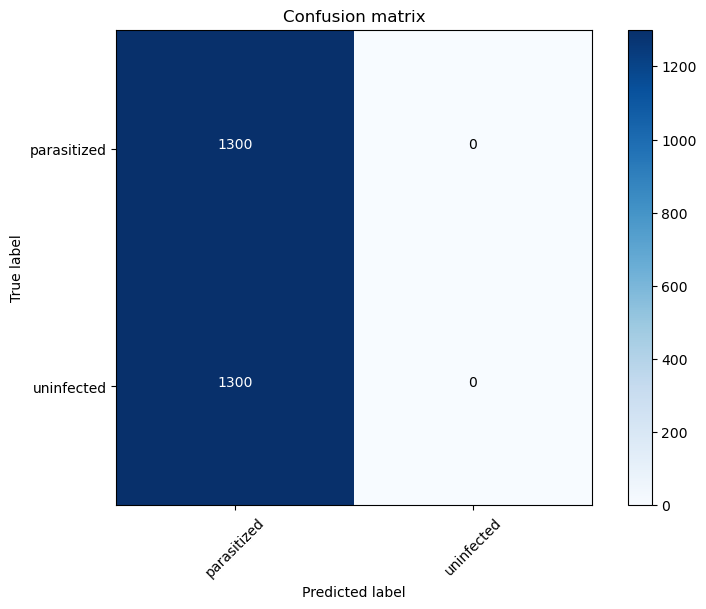

In [77]:
plot_confusion_matrix(cm, classes)

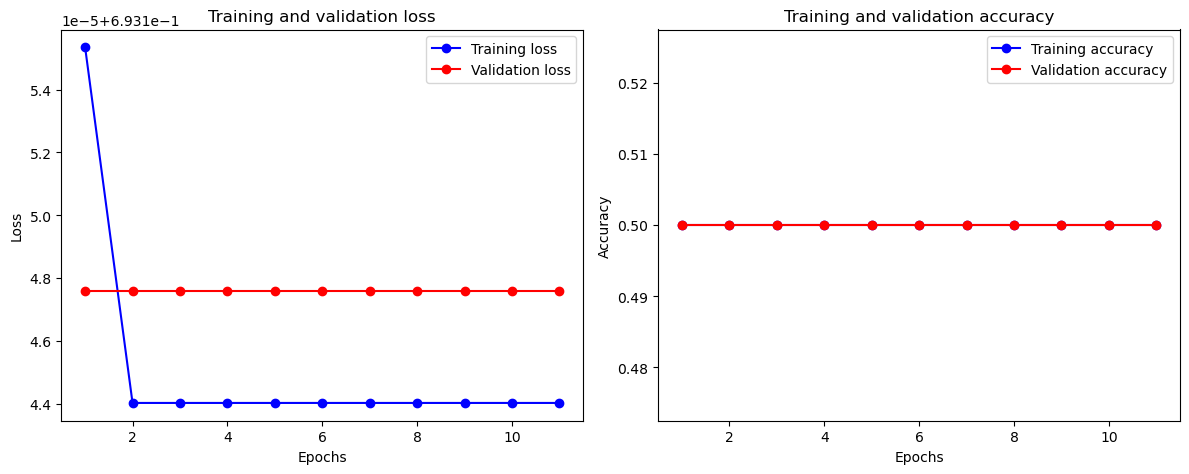

In [78]:
plot_history(history_ft)

<h3 style="color: #007ACC;"> Elección del tipo de Fine-Tuning </h3>

La elección del tipo de fine-tuning depende de varios factores:

**Tamaño del conjunto de datos objetivo:**

- Si el conjunto de datos es pequeño, es mejor utilizar fine-tuning parcial o transferencia directa.
- Si el conjunto de datos es grande, el fine-tuning total puede ser más efectivo.

**Similitud entre los dominios:**

- Si los dominios son muy similares, transferencia directa o fine-tuning parcial suelen ser suficientes.
- Si los dominios son diferentes, se recomienda el fine-tuning total o progresivo.

**Recursos computacionales:**

- Para recursos limitados, es preferible congelar capas y ajustar solo el clasificador.
- Para mayores recursos, se puede optar por enfoques más costosos como el fine-tuning total.

**Complejidad de la tarea:**

- Las tareas simples pueden beneficiarse de transferencia directa.
- Las tareas complejas suelen requerir fine-tuning total o progresivo.

<h3 style="color: #007ACC;"> Problemas Comunes y Soluciones en el Fine-Tuning </h3>

El Fine-Tuning, aunque es una técnica poderosa en aprendizaje automático, no está exento de desafíos. Uno de los problemas más frecuentes es el **overfitting**, que ocurre cuando el modelo se ajusta demasiado a los datos de entrenamiento y pierde capacidad de generalizar. Esto suele ser resultado de conjuntos de datos pequeños o del exceso de ajustes durante el entrenamiento. Para prevenirlo, se pueden implementar técnicas como la regularización mediante Dropout o L2 regularization, el uso de *early stopping* para detener el entrenamiento cuando las métricas de validación dejan de mejorar, o la ampliación artificial del conjunto de datos con *data augmentation*.

Por otro lado, el **underfitting** representa el caso contrario, en el que el modelo no aprende lo suficiente como para captar patrones significativos en los datos. Esto puede suceder si la tasa de aprendizaje es muy baja, si las capas del modelo preentrenado permanecen congeladas durante todo el entrenamiento, o si el modelo es demasiado simple. Soluciones comunes incluyen ajustar la tasa de aprendizaje, descongelar gradualmente las capas superiores del modelo y aumentar su complejidad agregando más neuronas o capas.

En tareas de clasificación, el desbalance entre clases es un desafío recurrente. Las clases mayoritarias tienden a dominar el entrenamiento, lo que sesga los resultados. Este problema puede abordarse asignando pesos diferentes a las clases, aplicando sobremuestreo para aumentar las muestras de las clases menos representadas, o generando nuevos ejemplos de datos específicos con técnicas de *data augmentation*.

Otro problema habitual es la falta de convergencia, donde el modelo no logra minimizar la función de pérdida y, por lo tanto, no alcanza un buen desempeño. Esto puede deberse a una tasa de aprendizaje mal configurada, ya sea demasiado alta o demasiado baja, o a una inicialización de pesos inadecuada. Para solucionarlo, se pueden usar optimizadores robustos como Adam o SGD con momentum, aplicar *learning rate schedules* para ajustar dinámicamente la tasa de aprendizaje, o asegurarse de que los pesos iniciales sean compatibles con el modelo preentrenado.

A veces, el modelo preentrenado elegido no se adapta bien a la nueva tarea, especialmente si los datos del preentrenamiento difieren significativamente de los datos de la tarea actual. En estos casos, es recomendable elegir un modelo más adecuado, como BERT para tareas de procesamiento del lenguaje natural o EfficientNet para visión por computadora, y ajustar más capas intermedias del modelo para capturar mejor las características relevantes.

<h2 style="color: #007ACC;"> Hugging Face </h2>

[**Hugging Face**](https://huggingface.co/) es una de las plataformas más populares para el desarrollo y uso de modelos de aprendizaje profundo, especialmente en el campo del procesamiento del lenguaje natural (NLP). Ofrece herramientas y bibliotecas como **Transformers** que permiten acceder a modelos preentrenados diseñados para resolver tareas complejas.

<h3 style="color: #007ACC;"> Relación entre Hugging Face y Fine-Tuning </h3>

Hugging Face facilita el fine-tuning al proporcionar:

1. **Modelos preentrenados:**  
Los modelos disponibles en Hugging Face están preentrenados en grandes conjuntos de datos (como Wikipedia o Common Crawl), capturando características generales del lenguaje.
   
2. **Adaptación específica:**  
Estos modelos se pueden ajustar para tareas específicas con datos personalizados mediante fine-tuning, utilizando las herramientas de Hugging Face.

3. **Interfaces sencillas:**  
Hugging Face permite combinar su API con frameworks como TensorFlow/Keras o PyTorch, simplificando el proceso de fine-tuning.

4. **Datasets:**  
La plataforma ofrece acceso a una amplia gama de conjuntos de datos etiquetados listos para el entrenamiento.

5. **Optimización avanzada:**  
Hugging Face proporciona optimizadores como **AdamW**, que son ideales para ajustar modelos preentrenados de forma eficiente.

<h3 style="color: #007ACC;"> Ventajas de usar Hugging Face para Fine-Tuning </h3>

- Acceso a miles de modelos preentrenados en diferentes lenguajes y dominios.
- Soporte para múltiples tareas, como clasificación de texto, traducción, respuesta a preguntas y más.
- Integración perfecta con TensorFlow/Keras, PyTorch y otros frameworks.
- Reducción significativa del tiempo de desarrollo al reutilizar modelos preentrenados.